# Create Decadal Panel Plots
Panel plots of decadal snow drought frequency

In [1]:
# package imports
import sys
sys.path.insert(0, '../notebooks')
from imports import *

# axes grid for 
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes


states = cfeature.NaturalEarthFeature(category='cultural',
                                     name='admin_1_states_provinces_shp',
                                     scale='50m',
                                     facecolor='none',
                                     edgecolor='black',
                                     linewidth=1)
mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")

In [5]:
# compute decadal averages
def to_decadal(rootdir, ens_num: str, threshold : float=-1.3, low_scen = ""):
    """Computes decadal frequency of Snow Drought (eg D2 snow drought) across the US West"""
    # get files
    hist_file = os.path.join(rootdir, f"hist/hist_monthly_ens_{ens_num}.nc")
    future_file = os.path.join(rootdir, f"future{low_scen}/future_monthly_ens_{ens_num}.nc")
    
    # open datsets and concat
    hist_zscores = xr.open_dataset(hist_file)
    future_zscores = xr.open_dataset(future_file)
    zscores = xr.concat([hist_zscores, future_zscores], dim='time').sortby('time')

    
    # reindex to West CONUS (remove Canada) and convert time to pandas
    zscores = zscores.reindex(lat = zscores.lat[zscores.lat <=49])
    zscores = zscores.sel(time=is_winter(zscores['time.month']))
    #zscores['time'] = zscores.indexes['time'].to_datetimeindex()
    
    # resample to 10 year frequency
    zscores = (zscores < threshold).resample(time="20Y", closed='right').sum()
    
        
    # open mask for snowy region and add time dimension corresponding to zscores
    mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")
    mask = mask_ds.expand_dims(dim={'time': zscores.time})
    
    # mask to snowy regions
    zscores = zscores.where(mask.snow > 20)
    
    return zscores

In [6]:
def is_winter(month):
    return (month <=4) | (month >=10)
rootdir = "/work/Julian.Schmitt/data/zscores/snowi/"
all_ens_members = [to_decadal(rootdir, str(i).zfill(2)) for i in range(1, 31)]

# get the ensemble mean
ens_mean = sum([ens.zscores for ens in all_ens_members])/30

In [7]:
ens_mean.indexes['time']

CFTimeIndex([1921-12-31 00:00:00, 1941-12-31 00:00:00, 1961-12-31 00:00:00,
             1981-12-31 00:00:00, 2001-12-31 00:00:00, 2021-12-31 00:00:00,
             2041-12-31 00:00:00, 2061-12-31 00:00:00, 2081-12-31 00:00:00,
             2101-12-31 00:00:00],
            dtype='object', length=10, calendar='julian', freq='20A-DEC')

In [8]:
def plot_decadal_samp(dataset, title: str = "Severe Snow Drought Occurrence for SPEAR Ensemble Mean"):
    """Plots 2*decadal map for selected times - useful for poster or presentation figures"""
    projection = ccrs.PlateCarree()
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    cmap = matplotlib.cm.get_cmap("RdBu_r")
    cmap.set_bad(color='gray')
    vmin, vmax = 0, 100
    fig = plt.figure(figsize=(30,20))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(2, 3),
                    axes_pad=0.65,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_mode

    for k, ax in enumerate(axgr):
        #i = [5,9,11,13,15,17][k]
        i = [3,5,6,7,8,9][k]
        #i=j+1
        if i >18: # truncate after 18 steps - can adjust in addition to axgr object
            break
        
        # add background features and set map extent
        ax.add_feature(cfeature.LAND, edgecolor="orange", facecolor="grey", zorder=0)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor="blue")
        ax.add_feature(cfeature.OCEAN, zorder=2)
        ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())
        ax.add_feature(states, edgecolor='black', linewidth=3)
        
        # add data
        data = (dataset[i]/70/2*100).where(mask_ds.snow >20).plot(ax=ax, transform = projection, add_colorbar=False,
                 cmap=cmap, zorder=1, vmin=vmin, vmax=vmax)
        
        # set title by decade
        decade = round(dataset.indexes['time'][i].year, -1)-20
        ax.set_title(f"{decade}s and {decade+10}s", fontsize=48)
    
    # add colorbar, title, and colorbar label
    axgr.cbar_axes[0].tick_params(labelsize=35)
    axgr.cbar_axes[0].colorbar(data)
    fig.suptitle(title, y=0.935, fontsize=50)
    fig.text(0.98, 0.20, 'Percentage of Months Presenting as SD', rotation=90, fontsize=45)
    return fig

/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  import sys
/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matp

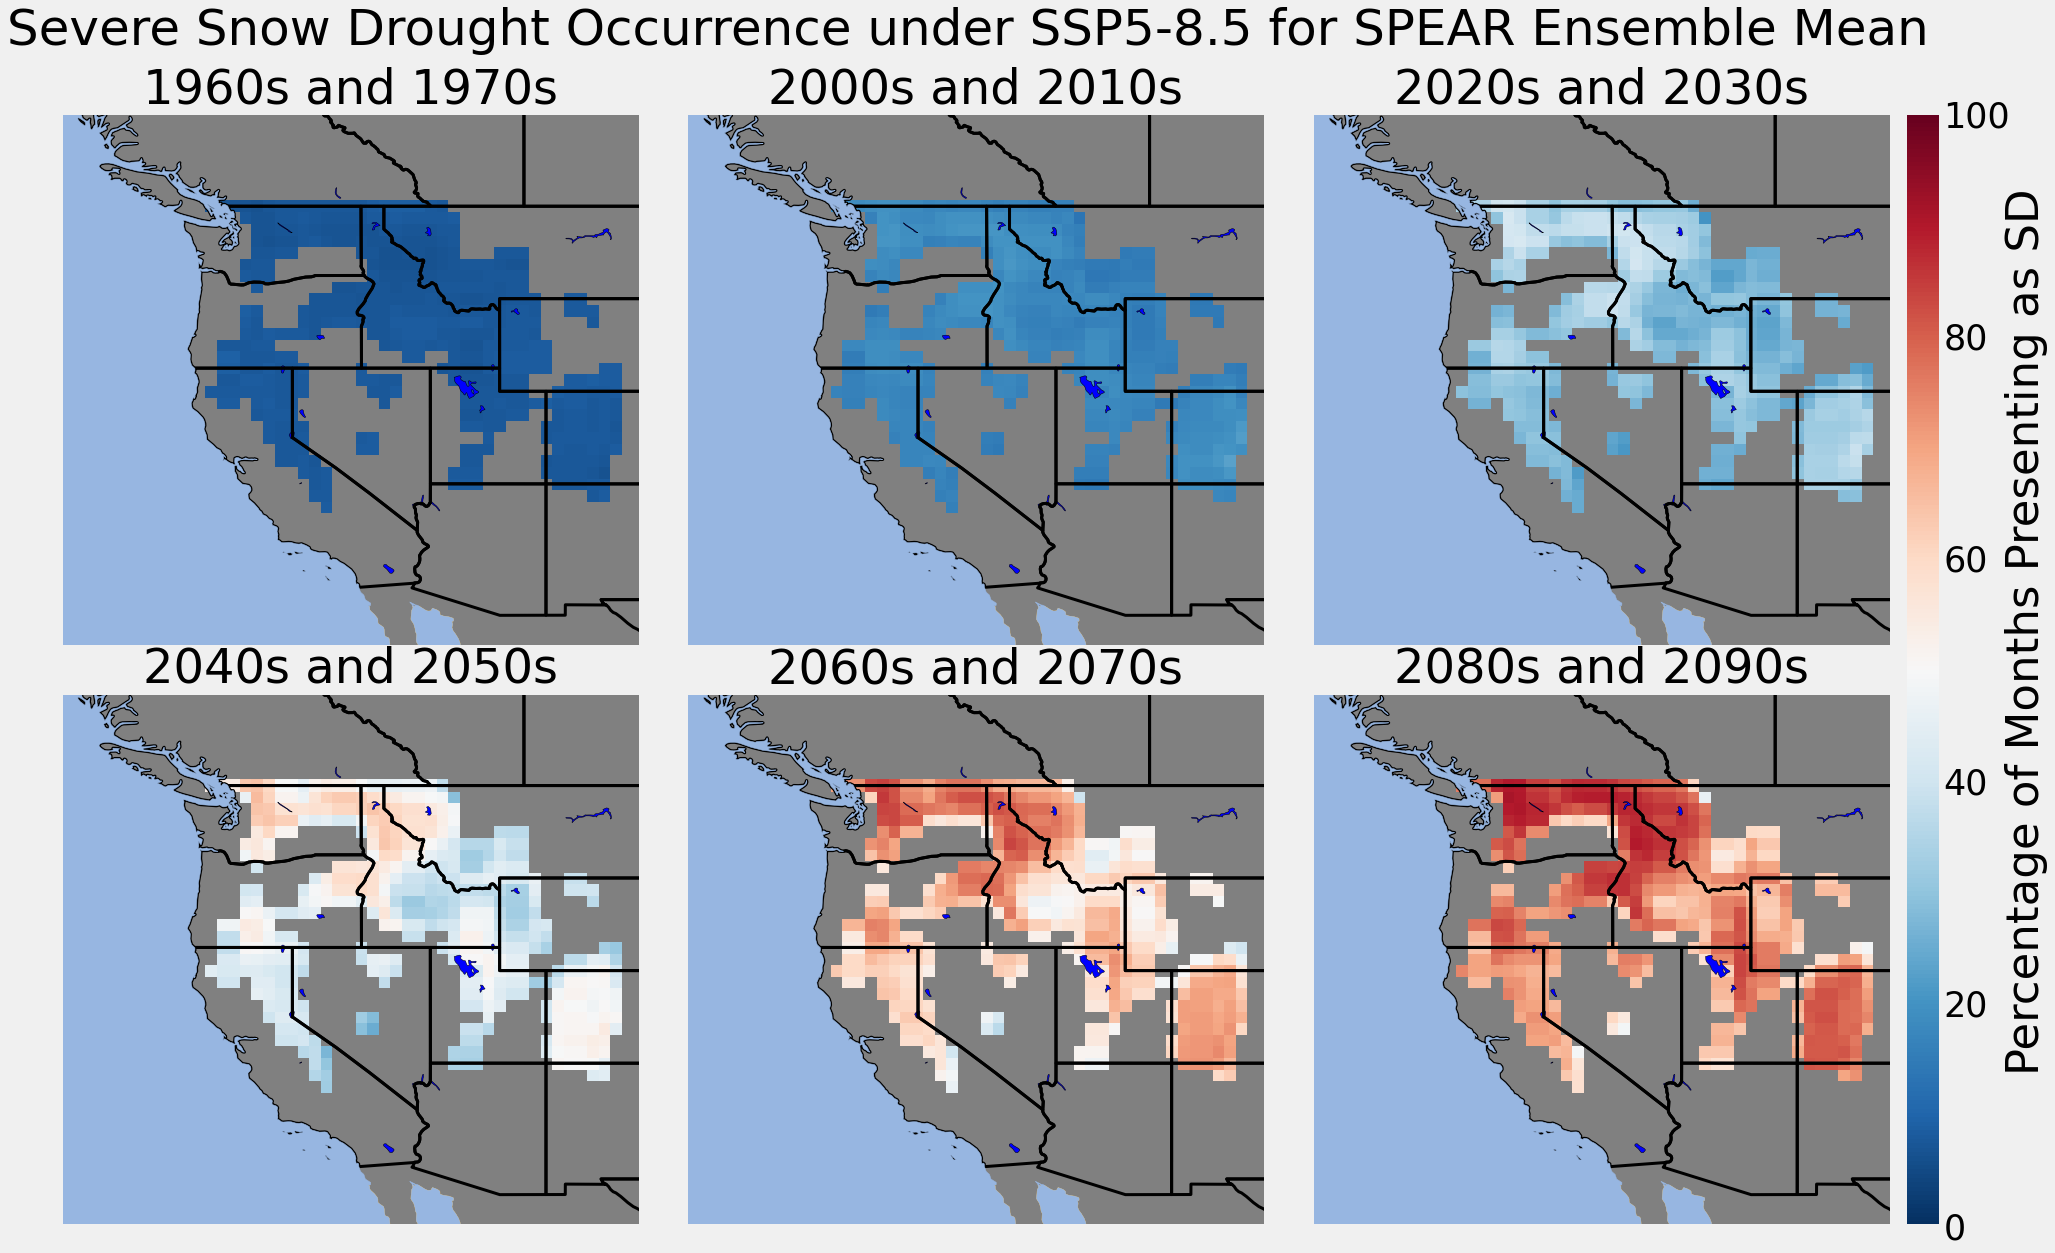

In [9]:
plt.style.use('fivethirtyeight')
f = plot_decadal_samp(ens_mean, "Severe Snow Drought Occurrence under SSP5-8.5 for SPEAR Ensemble Mean")
f.savefig("/home/Julian.Schmitt/plots/panel20_585.png", dpi=175)

# Same Calculation but for SSP245

In [10]:
# Calculate decadal averages for SSP245
rootdir45 = "/work/Julian.Schmitt/data/zscores/snowi/"
all_ens_members45 = [to_decadal(rootdir45, str(i).zfill(2), threshold = -1.3, low_scen = "245") for i in range(1, 31)]

# get ensemble mean for 4.5
ens_mean45 = sum([ens.zscores for ens in all_ens_members45])/30

/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  import sys
/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


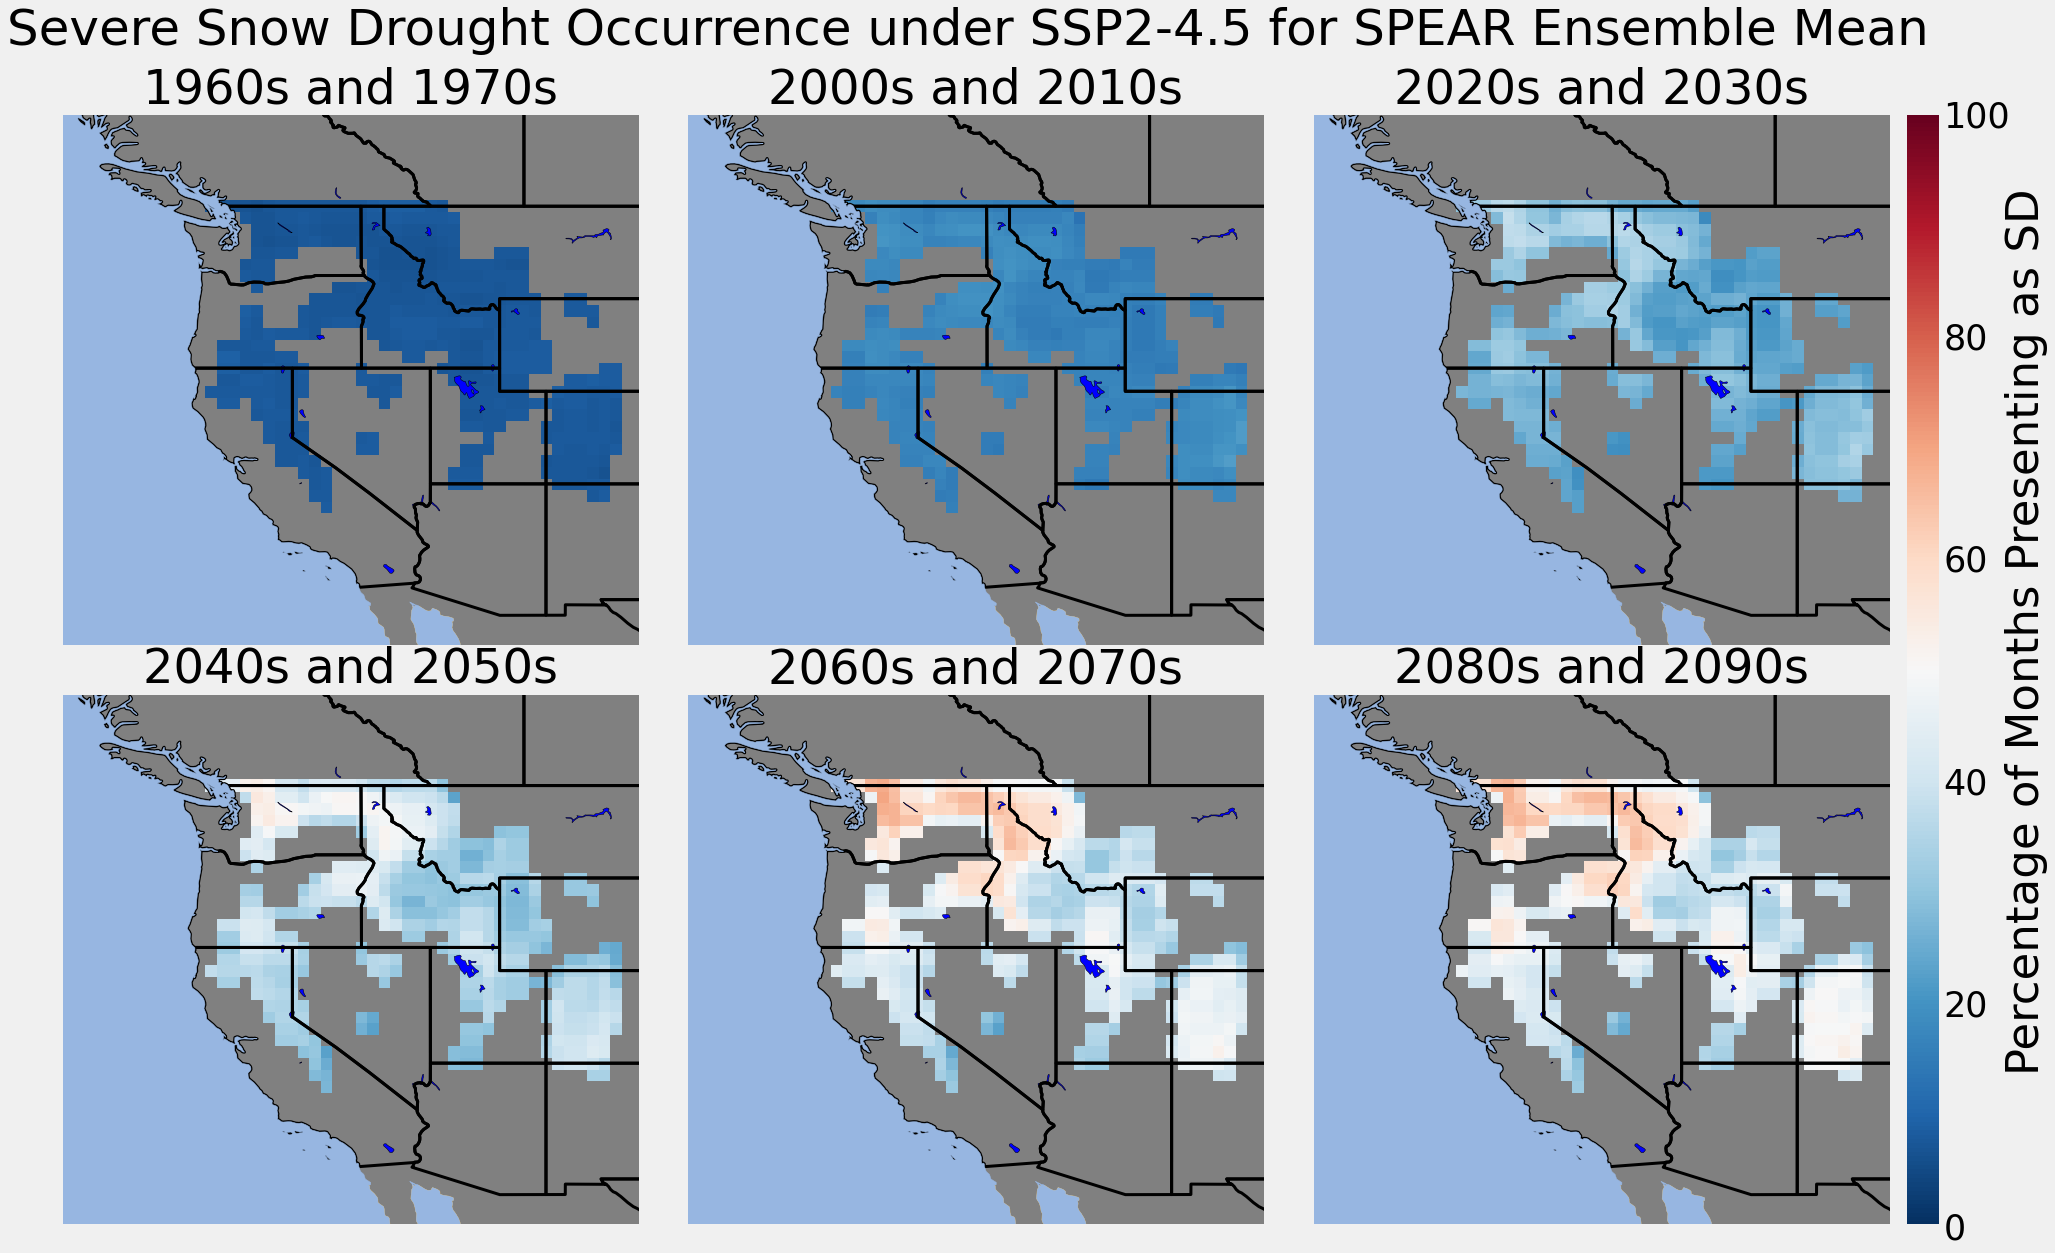

In [11]:
f245 = plot_decadal_samp(ens_mean45, "Severe Snow Drought Occurrence under SSP2-4.5 for SPEAR Ensemble Mean")
f245.savefig("/home/Julian.Schmitt/plots/panel20_245.png", dpi=175)